<a href="https://colab.research.google.com/github/jennifertramsu/MAIS202_Group1/blob/main/Code/MAIS202_Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------------------------------------------------------------------------------
# MAIS202 Group 1 - Fall 2022 Final Project
# Jennifer Tram Su, Lucy Mao
# Image Colourization
#
# Input : Single channel representation of greyscale image
# Output : Two channel representation of colourized image
#
# https://algoritmaonline.com/image-colorization/
# https://xiangyutang2.github.io/auto-colorization-autoencoders/
# https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04
# ----------------------------------------------------------------------------------------------

# File Handling
import glob
from google.colab import files as f
from google.colab import drive

# Manipulation
import numpy as np
import json 

# Visualization
from google.colab.patches import cv2_imshow
from skimage.color import rgb2lab, lab2rgb
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Models
import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import Reshape
from keras.layers import Concatenate
from keras.utils import plot_model
import numpy as np

# Presentation
#from flask import Flask, flash, request, redirect, url_for, render_template


In [2]:
!pip install -q kaggle

In [3]:
f.upload()
! mkdir /content/.kaggle
! cp kaggle.json /content/.kaggle/
!mv .kaggle /root/

Saving kaggle.json to kaggle.json


In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [06:43<00:00, 23.9MB/s]
100% 8.16G/8.16G [06:43<00:00, 21.7MB/s]


In [6]:
!unzip /content/flickr-image-dataset

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5354911151.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [7]:
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [8]:
# Path to dataset
path = '/content/flickr30k_images/flickr30k_images/'
extra = path + "flickr30k_images"
!rm -rf extra

files = glob.glob(path + "*.jpg")

In [9]:
# Preprocessing

def preprocess(img_list):
    l_list = [0]*len(img_list)
    ab_list = [0]*len(img_list)

    for i in range(len(img_list)):
      image = cv2.imread(img_list[i])

      # Resize image
      image = cv2.resize(image, (224, 224))

      # Convert to LAB space
      lab = rgb2lab(image)

      # Extract L
      l_list[i] = lab[:, :, 0].reshape((224, 224, 1))
#      l_list[i] = np.stack((l_list[i],)*3, axis=2).reshape((224, 224, 3))

      ab_list[i] = lab[:, :, 1:]

    l_list = np.array(l_list)
    ab_list = np.array(ab_list)

    return l_list, ab_list


In [10]:
def visualize(l, ab):
  l = l.reshape((224, 224, 1))
  
  a =  ab[:, :, 0].reshape((224, 224, 1))
  b = ab[:, :, 1].reshape((224, 224, 1))

  outimg = np.stack((l, a, b), axis=2)

  outimg = outimg.reshape((224, 224, 3))

  r = lab2rgb(outimg)*255
  cv2_imshow(r)

In [13]:
class CNN(Model):

  def __init__(self, path = None):
    super().__init__()
    if path: # Load saved model
      self.model = tf.keras.models.load_model(path)
    else: # Training new model
      self.model_input = Input(shape=(224, 224, 1,))

      # Feature extractor model
      self.extractor_input = Input(shape=(4096,))
      self.image_feature = Dropout(0.5)(self.extractor_input)
      self.image_feature = Dense(1024, activation='relu')(self.image_feature)

      encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(self.model_input)
      encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
      encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
      encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
      encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
      encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
      encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
      encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

      # concat_shape = (np.uint32(encoder_output.shape[1]), np.uint32(encoder_output.shape[2]),np.uint32(self.extractor_input.shape[-1]))

      # image_feature = RepeatVector(int(concat_shape[0]*concat_shape[1]))(self.extractor_input)
      # image_feature = Reshape(concat_shape)(image_feature)

      # fusion_output = Concatenate(axis=3)([encoder_output, image_feature])
    
      decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
      decoder_output = UpSampling2D((2, 2))(decoder_output)
      decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
      decoder_output = UpSampling2D((2, 2))(decoder_output)
      decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
      decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
      decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
      decoder_output = UpSampling2D((2, 2))(decoder_output)

      self.model = Model(inputs=[self.model_input], outputs=decoder_output)
      self.model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
      # summarize model
      #print(self.model.summary())
      #plot_model(model, to_file='autoencoder_colorization_merged.png', show_shapes=True)
      

In [14]:
# Performing gridsearch?
# for each hyperparameter:
#   for each set of data:
#     if not first iteration:
#       load previous model
#     else:
#       create new model
#
#     X = l_files[i*200:(i+1)*200]
#     y = ab_files[i*200:(i+1)*200]
#     train model
#     save metrics (loss, accuracy)
#     save model

In [15]:
LEARNING_RATES = [0.0001, 0.001, 0.01]

train = files[:30000]
test = files[30000:]

BATCH_SIZE = 50 # each epoch takes 4 iterations

In [16]:
print("Training model...")

for alpha in LEARNING_RATES:
  print(f"Training for learning rate {alpha}...")

  alpha_path = f"/content/mydrive/MyDrive/models/LEARNING_RATES/{alpha}"
  ! mkdir {alpha_path}

  for i in range(150):
    print(f"Starting batch {i} of 150...")
    model_path = alpha_path + f"/{i}"

    if i == 0:
      cnn = CNN().model
    elif (i-1) % 30 == 0:
      # Load previous model
      prev_path = alpha_path + f"/{i-1}"
      cnn = CNN(path = prev_path).model

    l_files, ab_files = preprocess(train[i*200:(i+1)*200])

    X = l_files
    y = ab_files

    cnn.fit(x=X,y=y,validation_split=0.1, epochs=5, batch_size=BATCH_SIZE, verbose=0, use_multiprocessing=True, workers=16)

    # Save metrics
    history = cnn.history.history
    print(history)

    with open(model_path + f"_metrics.txt", 'w') as f:
      f.write(json.dumps(history))
      
    # Save model
    if i % 30 == 0:
      cnn.save(model_path)

  # Out of loop, save final model
  cnn.save(alpha_path + "/FINAL")

    

Training model...
Training for learning rate 0.0001...
mkdir: cannot create directory ‘/content/mydrive/MyDrive/models/LEARNING_RATES/0.0001’: File exists
Starting batch 0 of 150...


KeyboardInterrupt: ignored

In [17]:
# Testing FINAL model

cnnmodel = CNN("/content/mydrive/MyDrive/models/LEARNING_RATES/0.0001/FINAL").model

l, ab = preprocess([test[10]])

out1 = cnnmodel.predict(x=l)

1/1 [==============================] - 8s 8s/step


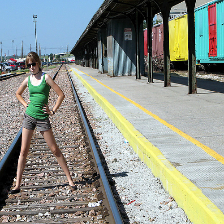

In [18]:
visualize(l[0], ab[0])

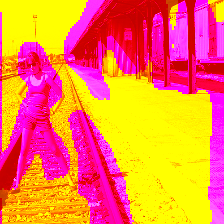

In [19]:
visualize(l[0], out1[0]*128)

In [20]:
# Testing FINAL model

cnnmodel = CNN("/content/mydrive/MyDrive/models/LEARNING_RATES/0.001/FINAL").model

l, ab = preprocess([test[10]])

out2 = cnnmodel.predict(x=l)

1/1 [==============================] - 0s 126ms/step


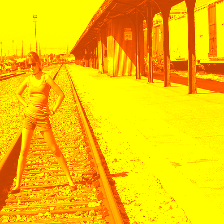

In [21]:
visualize(l[0], out2[0]*128)

In [22]:
# Testing FINAL model

cnnmodel = CNN("/content/mydrive/MyDrive/models/LEARNING_RATES/0.01/FINAL").model

l, ab = preprocess([test[10]])

out3 = cnnmodel.predict(x=l)

1/1 [==============================] - 0s 121ms/step


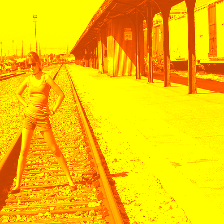

In [23]:
visualize(l[0], out3[0]*128)

In [24]:
# Print metrics for each model

losses = {}
acc = {}
val_loss = {}
val_acc = {}

for alpha in LEARNING_RATES:
  alpha_path = f"/content/mydrive/MyDrive/models/LEARNING_RATES/{alpha}"

  text_paths = glob.glob(alpha_path + "/*.txt")

  l = []
  a = []
  ll = []
  la = []

  for text in text_paths:

    with open(text) as f:
      data = json.load(f)

      l.extend(data['loss'])
      a.extend(data['acc'])
      ll.extend(data['val_loss'])
      la.extend(data['val_acc'])

    losses[alpha] = l
    acc[alpha] = a
    val_loss[alpha] = ll
    val_acc[alpha] = la


In [25]:
def print_metrics(loss, acc, val_loss, val_acc, title):

  epochs = np.arange(5*150)

  plt.figure(figsize=(10, 15))
  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  plt.legend(['Train', 'Validation'])
  plt.xlabel('Epoch')
  plt.ylabel("Loss")
  plt.title(title)

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc)
  plt.plot(epochs, val_acc)
  plt.legend(['Train', 'Validation'])
  plt.xlabel('Epoch')
  plt.ylabel("Accuracy")

  plt.show()
  

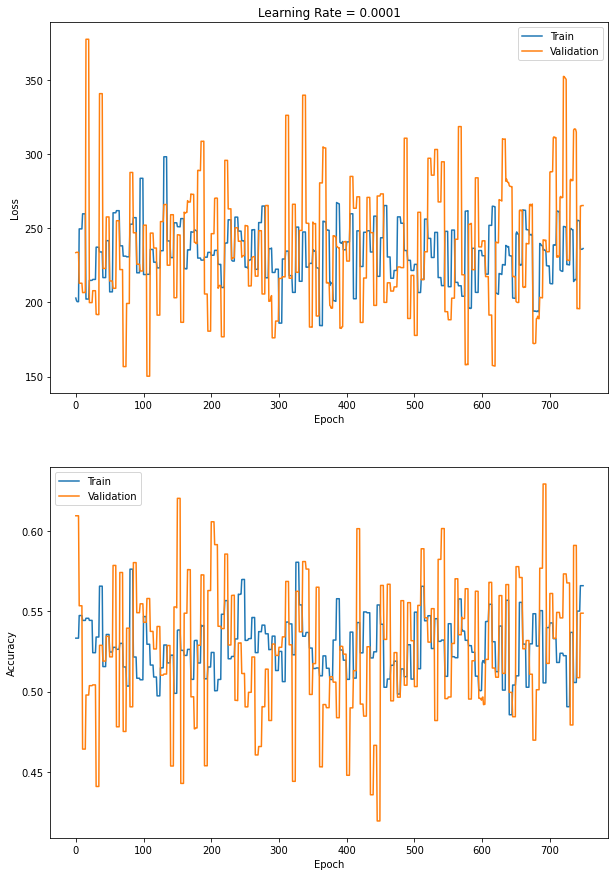

In [26]:
print_metrics(losses[0.0001], acc[0.0001], val_loss[0.0001], val_acc[0.0001], "Learning Rate = 0.0001")

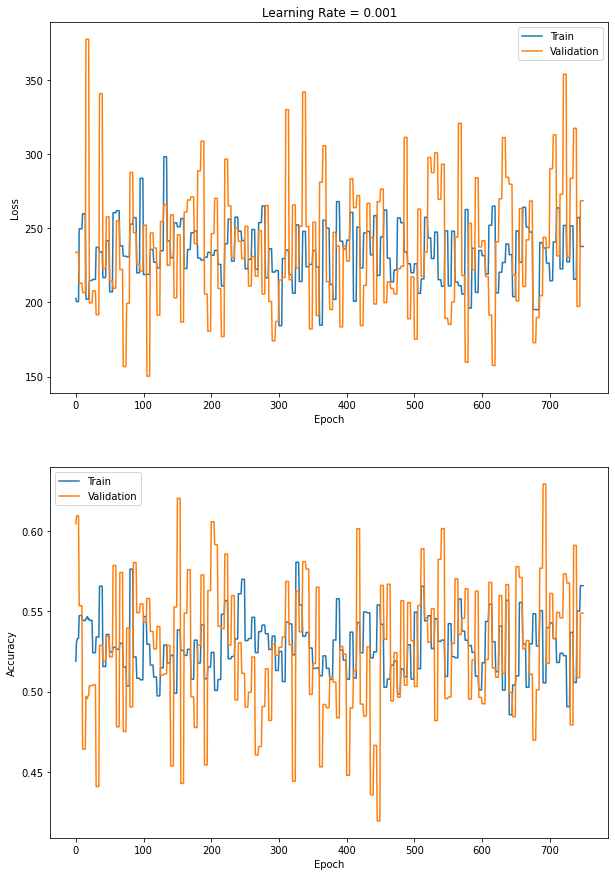

In [27]:
print_metrics(losses[0.001], acc[0.001], val_loss[0.001], val_acc[0.001], "Learning Rate = 0.001")

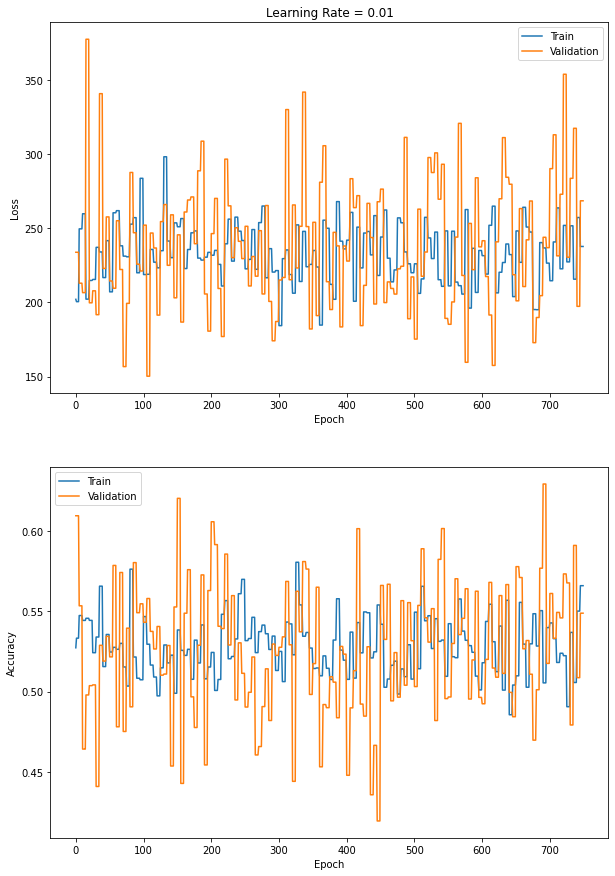

In [28]:
print_metrics(losses[0.01], acc[0.01], val_loss[0.01], val_acc[0.01], "Learning Rate = 0.01")